In [17]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

# Re-load the dataset
df = pd.read_csv('../data/transform/df_engineered.csv')

df.drop(['Unnamed: 0',], axis=1, inplace=True)

In [18]:
df.shape

(3040, 51)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and you have dropped the target variable 'result_match'
X = df.drop('result_match', axis=1)

# Elbow Method
sse = {}
for k in range(1, 50):  # Test different numbers of clusters (e.g., 1 to 10)
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    sse[k] = kmeans.inertia_  # Sum of squared distances to closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

# Silhouette Score
for k in range(2, 50):  # Silhouette score is only defined if number of labels is 2 <= n_labels <= n_samples - 1
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    print(f"Clusters: {k}, Silhouette Score: {silhouette_avg}")

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df.drop('result_match', axis=1))

In [ ]:
# Splitting the original dataset
X = df.drop('result_match', axis=True)
y = df['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

In [ ]:
import xgbfir

xgbfir.saveXgbFI(xgb_full, feature_names=X_train_full.columns, OutputXlsxFile='fir.xlsx')

In [ ]:
file_path = 'fir.xlsx'
fir = pd.read_excel(file_path)

# Extracting top features based on different metrics
top_gain_features = fir.sort_values(by='Gain', ascending=False).head(10)
top_fscore_features = fir.sort_values(by='FScore', ascending=False).head(10)
top_wfscore_features = fir.sort_values(by='wFScore', ascending=False).head(10)
top_avg_gain_features = fir.sort_values(by='Average Gain', ascending=False).head(10)
top_expected_gain_features = fir.sort_values(by='Expected Gain', ascending=False).head(10)

# Displaying the top features
top_features_summary = {
    "Top Features by Gain": top_gain_features['Interaction'].values,
    "Top Features by FScore": top_fscore_features['Interaction'].values,
    "Top Features by wFScore": top_wfscore_features['Interaction'].values,
    "Top Features by Average Gain": top_avg_gain_features['Interaction'].values,
    "Top Features by Expected Gain": top_expected_gain_features['Interaction'].values
}

top_features_summary

In [ ]:
# Load the data from the "Interaction Depth 1" and "Interaction Depth 2" sheets
interaction_depth_1 = pd.read_excel(file_path, sheet_name='Interaction Depth 1')
interaction_depth_2 = pd.read_excel(file_path, sheet_name='Interaction Depth 2')

# Display the first few rows of each sheet to understand their structure
interaction_depth_1_head = interaction_depth_1.sort_values('Gain', ascending=False).head(20)
interaction_depth_2_head = interaction_depth_2.sort_values('Gain', ascending=False).head(20)

interaction_depth_1_head

In [ ]:
interaction_depth_2_head

In [ ]:
s = pd.concat([interaction_depth_1_head['Interaction'], (interaction_depth_2_head['Interaction'])])

# Split each string by '|' and flatten the resulting lists
columns = [item for sublist in s.str.split('|') for item in sublist]

# Get unique values
unique_columns = list(set(columns))

print(unique_columns)

In [ ]:
# Assuming 'result_match' is the target variable
X = df[unique_columns]
y = df['result_match']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter Method: Selecting features using ANOVA F-test
k_values = range(6, X_train.shape[1], 1)
filter_accuracies = []

best_score = 0
best_n_features = 0

for k in k_values:
    # Select top k features
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Train XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_selected, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_selected)
    f1 = f1_score(y_test, y_pred, average='weighted')
    filter_accuracies.append(f1)
    
    # Compare and store the best score and corresponding number of features
    if f1 > best_score:
        best_score = f1

# Plotting the results
plt.plot(k_values, filter_accuracies, marker='o', label='Filter Method (ANOVA F-test)')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Filter Method Feature Selection')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best accuray Score: {best_score}")

In [70]:
interaction_depth_2_head

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,avg_player_rating_away|new_feature_3|new_featu...,339.522382,5,1.760634,0.352127,67.904476,187.513047,1,2,1,9,11,1,4.166667,13.60,2.4
1,new_feature_3|new_feature_4|player_rating_home...,267.168260,3,0.396366,0.132122,89.056087,37.679663,2,7,18,47,6,3,13.833333,8.00,2.0
2,home_shots_on_rolling|new_feature_4|new_feature_5,218.367299,2,0.335297,0.167648,109.183649,36.246243,3,20,27,40,3,4,16.166667,3.50,2.0
3,goals_ratio_rolling|new_feature_4|new_feature_5,141.447587,1,0.117325,0.117325,141.447587,16.595276,4,55,70,55,1,12,32.833333,2.00,2.0
4,avg_player_rating_away|new_feature_3|new_featu...,123.982038,2,0.165693,0.082847,61.991019,11.984598,5,21,60,70,12,19,31.166667,7.00,2.0
5,diff_player_10|diff_player_7|new_feature_3,110.906779,1,0.475877,0.475877,110.906779,52.778008,6,56,10,2,2,2,13.000000,0.00,2.0
6,new_feature_3|player_rating_away_player_11|pla...,110.777771,2,0.216217,0.108109,55.388885,12.082075,7,22,51,57,14,18,28.166667,4.50,2.0
7,avg_player_rating_away|avg_player_rating_home|...,106.489388,4,0.763345,0.190836,26.622347,28.214659,8,3,6,36,35,6,15.666667,7.75,3.0
8,diff_player_10|home_avg_goals_conceded|new_fea...,106.029018,1,0.229898,0.229898,106.029018,24.375825,9,57,49,29,4,7,25.833333,0.00,2.0
9,diff_player_11|new_feature_3|new_feature_3,102.836081,1,0.190058,0.190058,102.836081,19.544870,10,58,56,37,5,10,29.333333,0.00,2.0


In [72]:
s = pd.concat([interaction_depth_1_head['Interaction'], (interaction_depth_2_head['Interaction'])])

# Split each string by '|' and flatten the resulting lists
columns = [item for sublist in s.str.split('|') for item in sublist]

# Get unique values
unique_columns = list(set(columns))

print(unique_columns)

['diff_player_7', 'player_rating_home_player_8', 'avg_possession_home', 'avg_player_rating_home', 'home_shots_on_rolling', 'diff_player_11', 'shots_on_target_difference_rolling', 'new_feature_2', 'avg_possession_away', 'player_rating_away_player_11', 'new_feature_4', 'player_rating_home_player_10', 'goals_ratio_rolling', 'avg_player_rating_away', 'away_possession_rolling', 'home_possession_rolling', 'new_feature_5', 'diff_player_10', 'home_avg_goals_conceded', 'shots_on_target_ratio_rolling', 'new_feature_3']


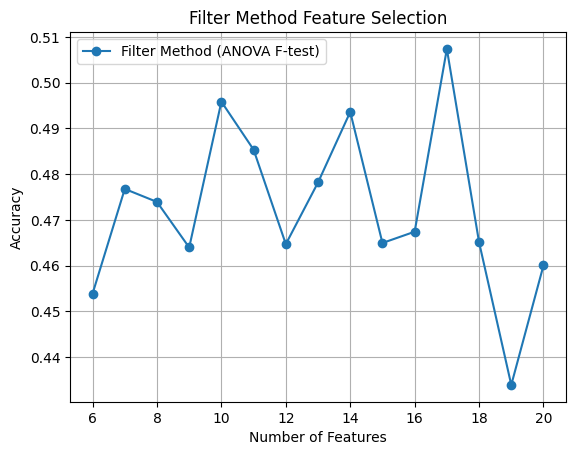

Best accuray Score: 0.5074012303485989


In [73]:
# Assuming 'result_match' is the target variable
X = df[unique_columns]
y = df['result_match']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter Method: Selecting features using ANOVA F-test
k_values = range(6, X_train.shape[1], 1)
filter_accuracies = []

best_score = 0
best_n_features = 0

for k in k_values:
    # Select top k features
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Train XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_selected, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_selected)
    f1 = f1_score(y_test, y_pred, average='weighted')
    filter_accuracies.append(f1)
    
    # Compare and store the best score and corresponding number of features
    if f1 > best_score:
        best_score = f1

# Plotting the results
plt.plot(k_values, filter_accuracies, marker='o', label='Filter Method (ANOVA F-test)')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Filter Method Feature Selection')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best accuray Score: {best_score}")

In [74]:
# Choose the number of features with the best accuracy
best_k = k_values[filter_accuracies.index(max(filter_accuracies))]

# Re-run the selection process for the best k
selector = SelectKBest(f_classif, k=best_k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Retrieve the selected feature names
selected_features = X_train.columns[selector.get_support()]

print("Selected features for k =", best_k, ":\n", selected_features)

Selected features for k = 17 :
 Index(['diff_player_7', 'player_rating_home_player_8',
       'avg_player_rating_home', 'home_shots_on_rolling', 'diff_player_11',
       'shots_on_target_difference_rolling', 'new_feature_2',
       'player_rating_away_player_11', 'new_feature_4',
       'player_rating_home_player_10', 'goals_ratio_rolling',
       'avg_player_rating_away', 'new_feature_5', 'diff_player_10',
       'home_avg_goals_conceded', 'shots_on_target_ratio_rolling',
       'new_feature_3'],
      dtype='object')


In [75]:
# Assuming 'result_match' is the target variable
X = df[selected_features]
y = df['result_match']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define a range for n_features_to_select
feature_range = range(6, X_train.shape[1], 2)

best_score = 0
best_n_features = 0

# Iterate over the range
for n_features in feature_range:
    model = XGBClassifier(random_state=42)

    # Create the RFE model and select n features
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe = rfe.fit(X_train, y_train)

    # Transform the training and testing sets
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Train the model on the reduced dataset
    model.fit(X_train_rfe, y_train)

    # Make predictions and evaluate using F1 score
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')

    # Compare and store the best score and corresponding number of features
    if score > best_score:
        best_score = score
        best_n_features = n_features

print(f"Best F1 Score: {best_score}")
print(f"Best number of features: {best_n_features}")

Best F1 Score: 0.48878661781264765
Best number of features: 16


In [18]:
X = df[selected_features]
y = df['result_match']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
f1_score = f1_score(y_test, y_pred_full,average='weighted')

f1_score

0.49690325825519505

In [20]:
# Choose the number of features with the best accuracy
best_k = k_values[filter_accuracies.index(max(filter_accuracies))]

# Re-run the selection process for the best k
selector = SelectKBest(f_classif, k=best_k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Retrieve the selected feature names
selected_features = X_train.columns[selector.get_support()]

print("Selected features for k =", best_k, ":\n", selected_features)

Selected features for k = 52 :
 Index(['home_avg_goals_scored', 'away_avg_goals_scored',
       'home_avg_goals_conceded', 'away_avg_goals_conceded',
       'home_streak_wins', 'away_streak_wins', 'home_sum_points',
       'away_sum_points', 'points_diff', 'win_eachother_home',
       'win_eachother_away', 'avg_possession_home', 'avg_possession_away',
       'avg_shoton_home', 'avg_shoton_away', 'avg_player_rating_home',
       'avg_player_rating_away', 'diff_player_7', 'diff_player_8',
       'diff_player_9', 'diff_player_10', 'diff_player_11',
       'home_goals_rolling', 'away_goals_rolling', 'home_possession_rolling',
       'away_possession_rolling', 'home_shots_on_rolling',
       'away_shots_on_rolling', 'interaction_home_player_7_8',
       'interaction_away_player_7_8',
       'player_rating_home_player_7 player_rating_away_player_7',
       'player_rating_home_player_7 home_possession_rolling',
       'player_rating_home_player_7 away_possession_rolling',
       'player_ratin

In [21]:
df[selected_features].shape

(3040, 52)

In [22]:
from sklearn.metrics import classification_report

# Assuming 'result_match' is the target variable
X = df[selected_features]
y = df['result_match']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define a range for n_features_to_select
feature_range = range(6, X_train.shape[1], 2)

best_score = 0
best_n_features = 0

# Iterate over the range
for n_features in feature_range:
    model = XGBClassifier(random_state=42)

    # Create the RFE model and select n features
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe = rfe.fit(X_train, y_train)

    # Transform the training and testing sets
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Train the model on the reduced dataset
    model.fit(X_train_rfe, y_train)

    # Make predictions and evaluate using F1 score
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')

    # Compare and store the best score and corresponding number of features
    if score > best_score:
        best_score = score
        best_n_features = n_features

print(f"Best F1 Score: {best_score}")
print(f"Best number of features: {best_n_features}")

TypeError: 'numpy.float64' object is not callable

In [18]:
X = df[selected_features]
y = df['result_match']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
f1_score = f1_score(y_test, y_pred_full,average='weighted')

classification_report()

f1_score

0.5032894736842105